# Ensemble

Revisiting our Multi-Output Logistic Regression, we found something interesting:
- Logistic Regression has a very high False Positive and very low False Negative near zero.
- Decision Tree has very low False Positive and some False Negative.

In term of down time, our decision to use Decision Tree is definitely better than Logistic Regression.

However, it is possible we could combine them and get the best of both models.



In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
X_train=pd.read_csv('data/X_train.csv')
y_train=pd.read_csv('data/y_train.csv')
X_test=pd.read_csv('data/X_test.csv')
y_test=pd.read_csv('data/y_test.csv')

y_train_omf = y_train['Machine failure']
y_test_omf = y_test['Machine failure']

X_train_reduced = X_train.drop(columns=['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)'])
X_test_reduced = X_test.drop(columns=['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)'])

print(X_train_reduced.columns)
print(y_test.columns)

Index(['Type', 'Rotational speed (rpm)', 'Tool wear (min)', 'Strain (minNm)',
       'Power (W)', 'Temperature Difference (K)'],
      dtype='object')
Index(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], dtype='object')


In [105]:
from sklearn.ensemble import  RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

clr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=42)
cdt=DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=30, min_samples_split=20)
mdt=DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=30, min_samples_split=20)
mlr=LogisticRegression(random_state=42, solver="liblinear")
rf = RandomForestClassifier(random_state=42, max_depth=10) 
# Best hyperparameters:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 30}
stacking_estimators = [ 
    ('cdt', cdt),
    ('rf', rf),  # Add another to provide tie-breaker capability
]
cstdt = StackingClassifier(estimators=stacking_estimators, final_estimator=mdt)
cstlr = StackingClassifier(estimators=stacking_estimators, final_estimator=mlr)

voting_estimators = [ # we need 3 classifiers for voting ensemble methods
    ('clr', clr),
    ('cdt', cdt),
    ('rf', rf),  # Add another to provide tie-breaker capability
]

cvh = VotingClassifier(estimators=voting_estimators,voting='hard')
cvs = VotingClassifier(estimators=voting_estimators,voting='soft')

In [106]:
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.multioutput import MultiOutputClassifier

def get_ml_perf_machine_failure(name, clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target='Machine failure'):
    clf = MultiOutputClassifier(clf)
    clf.fit(X_train, y_train)
    y_train_pred= clf.predict(X_train)
    y_train_pred = pd.DataFrame(y_train_pred, columns=y_test.columns)
    y_test_pred = clf.predict(X_test)
    y_test_pred = pd.DataFrame(y_test_pred, columns=y_test.columns)
    y_test_pred_omf = y_test_pred[target]
    y_train_pred_omf = y_train_pred[target]
    y_train_omf = y_train[target]
    y_test_omf = y_test[target]
    f2_train=fbeta_score(y_train_omf, y_train_pred_omf, beta=2)
    f2_test=fbeta_score(y_test_omf, y_test_pred_omf, beta=2)
    train_recall=recall_score(y_train_omf, y_train_pred_omf)
    test_recall=recall_score(y_test_omf, y_test_pred_omf)
    train_precision=precision_score(y_train_omf, y_train_pred_omf, zero_division=0)
    test_precision=precision_score(y_test_omf, y_test_pred_omf, zero_division=0)
    train_accuracy=accuracy_score(y_train_omf, y_train_pred_omf)
    test_accuracy=accuracy_score(y_test_omf, y_test_pred_omf)
    predictor_name = clf.__class__.__name__
    cm = confusion_matrix(y_train_omf, y_train_pred_omf)
    train_tn, train_fp, train_fn, train_tp = cm.ravel()
    cm = confusion_matrix(y_test_omf, y_test_pred_omf)
    test_tn, test_fp, test_fn, test_tp = cm.ravel()
    result = {
        "multi-output-classifier": clf,
        "f2_train": f2_train,
        "f2_test": f2_test,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_recall":train_recall,
        "test_recall": test_recall,
        "test_precision": test_precision,
        "train_precision":train_precision,
        "predictor_name": predictor_name,
        "train_fp": train_fp,
        "train_fn": train_fn,
        "test_fp": test_fp,
        "test_fn": test_fn,
        "train_tp": train_tp,
        "train_tn": train_tn,
        "test_tp": test_tp,
        "test_tn": test_tn,
        "test_pred": y_test_pred,
        "train_pred": y_train_pred,
        "name": name        
    }
    return result

def evaluate_models(models:dict,  X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target='Machine failure'):
    results = []
    print("Evaluate models for ", target)
    for name, model in models.items():
        results.append(get_ml_perf_machine_failure(name, model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target=target))
    results.sort(reverse=True, key=lambda result: (result["f2_test"],result["test_accuracy"]))
    print(" -- Sorted result --")
    for result in results:
        print(f"{result["name"]:30} : f2-test {result["f2_test"]:.4f} | test-fn {result["test_fn"]:10} | test-fp {result["test_fp"]:10}  | f2-train {result["f2_train"]:20} | | train_fn {result["train_fn"]:10} | train_fp {result["train_fp"]:10}  |accuracy {result["test_accuracy"]:.4f}")
    return results

In [107]:
from sklearn.tree import DecisionTreeClassifier
names = [
    "Random Forest",
    "Random Forest Tuned",
    "Decision Tree",
    "Stacking Decision Tree",
    "Stacking Logistic Regression",
    "Voting Soft",
    "Voting Hard"
]

classifiers = [
    RandomForestClassifier(random_state=42, max_depth=10), 
    RandomForestClassifier(random_state=42, max_depth=10, min_samples_leaf=10, min_samples_split=30, criterion='gini'), 
    DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=30, min_samples_split=20),
    cstlr,
    cstdt,
    cvs,
    cvh
]

models = {name: clf for name, clf in zip(names, classifiers)}
results_reduced = evaluate_models(models, X_train=X_train_reduced, X_test=X_test_reduced, target='Machine failure') # use reduced features

best_clf = results_reduced[0]["multi-output-classifier"]

best_clf


Evaluate models for  Machine failure
 -- Sorted result --
Random Forest                  : f2-test 0.8841 | test-fn          9 | test-fp          4  | f2-train   0.8600148920327625 | | train_fn         47 | train_fp          0  |accuracy 0.9935
Stacking Decision Tree         : f2-test 0.8841 | test-fn          9 | test-fp          4  | f2-train   0.8470149253731343 | | train_fn         51 | train_fp          1  |accuracy 0.9935
Decision Tree                  : f2-test 0.8665 | test-fn          9 | test-fp         11  | f2-train   0.8284671532846716 | | train_fn         51 | train_fp         31  |accuracy 0.9900
Voting Soft                    : f2-test 0.8665 | test-fn          9 | test-fp         11  | f2-train   0.8388278388278388 | | train_fn         49 | train_fp         24  |accuracy 0.9900
Voting Hard                    : f2-test 0.8665 | test-fn          9 | test-fp         11  | f2-train   0.8394428152492669 | | train_fn         49 | train_fp         23  |accuracy 0.9900
Stackin

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                       random_state=42))

In [70]:
import pprint
pprint.pprint(best_clf.get_params())
pprint.pprint(best_clf.estimator.get_params())

{'estimator': StackingClassifier(estimators=[('cdt',
                                DecisionTreeClassifier(max_depth=5,
                                                       min_samples_leaf=30,
                                                       min_samples_split=20,
                                                       random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42,
                                                      solver='liblinear')),
 'estimator__cdt': DecisionTreeClassifier(max_depth=5, min_samples_leaf=30, min_samples_split=20,
                       random_state=42),
 'estimator__cdt__ccp_alpha': 0.0,
 'estimator__cdt__class_weight': None,
 'estimator__cdt__criterion': 'gini',
 'estimator__cdt__max_depth': 5,
 'estimator__cdt__max_features': None,
 'estimator__cdt__max_leaf_nodes': None,
 'estimator__cdt__min_impurity_decrease': 0.0,
 'estimator__

One of the problem we discovered in our earlier attempt to use Decision Tree is the failure to detect TWF

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

def display_cm(pred, actual):
    no_of_label = len(pred.columns)
    i = 0
    no_of_column = 6
    left_over = no_of_label % no_of_column
    no_of_row = no_of_label // no_of_column+left_over
    plt.figure(figsize=(30,5))
    for label in pred.columns:
        i +=1
        ax=plt.subplot(no_of_row, no_of_column, i)
        cm = confusion_matrix(actual[label],pred[label])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['P', 'F'])
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.title(label=label)
    plt.show()

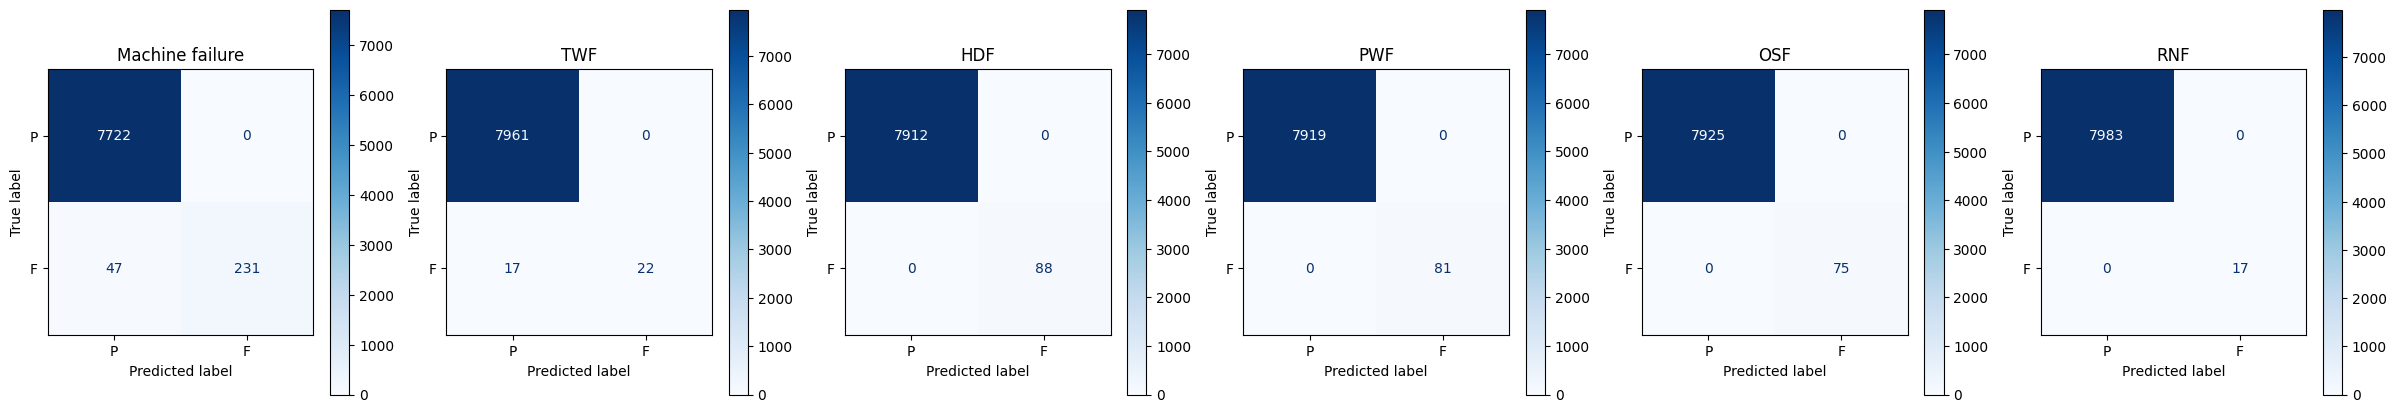

In [95]:
y_pred=best_clf.predict(X_train_reduced)
y_pred = pd.DataFrame(y_pred, columns=y_train.columns)
display_cm(y_pred, y_train)

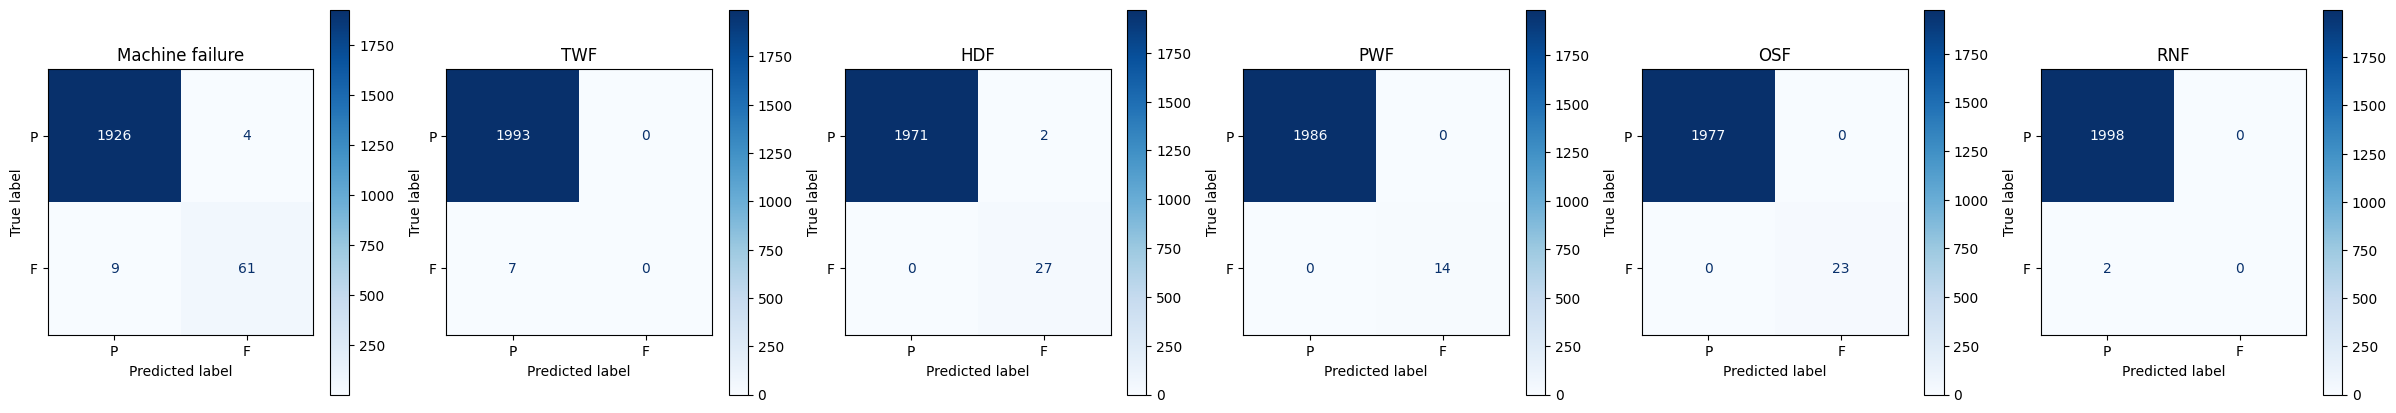

In [94]:
y_pred=best_clf.predict(X_test_reduced)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
display_cm(y_pred, y_test)

## Conclusion

Our Decision Tree classifier is simple and yet perform sufficiently for our need as it matches XGBoost performance